# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [4]:
#Import all the required libraries
import os, glob, random
import pickle, time
import warnings
import zipfile
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from nltk.tokenize import wordpunct_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings('ignore')
stopwords = stopwords.words('english')

if os.path.exists("./archive"):
    os.rename("./archive","./flikr8k")
elif os.path.exists("./archive.zip"):
    with zipfile.ZipFile("archive.zip", "r") as zip_ref:
        zip_ref.extractall("./flikr8k") 


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [3]:
#Import the dataset and read the image into a seperate variable

images='./flikr8k/Images'
all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

data = pd.read_csv("./flikr8k/captions.txt")
data = data.to_dict("records")
print("The total captions present in the dataset: {}".format(len(data)))

img_path_map = {}
for x in all_imgs:
    img_path_map[x.rsplit("/",1)[1]] = x

for x in data:
    x["path"] = img_path_map[x["image"]]
print("paths of images are mapped to captions")

The total images present in the dataset: 8091
The total captions present in the dataset: 40455
paths of images are mapped to captions


In [10]:
random.sample(data,2)

[{'image': '2054308369_f9c6ec7815.jpg',
  'caption': 'A toddler girl puckering up for a kiss from the dog .',
  'path': './flikr8k/Images/2054308369_f9c6ec7815.jpg'},
 {'image': '260828892_7925d27865.jpg',
  'caption': 'a lone person walking in the distance on a long beach .',
  'path': './flikr8k/Images/260828892_7925d27865.jpg'}]

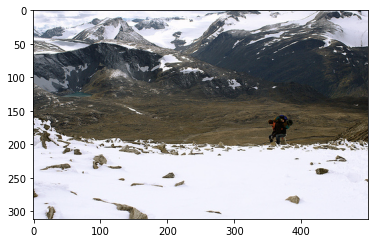

Caption is :  The person is in the snowy mountains .


In [11]:
#Visualise both the images & text present in the dataset
i = random.randint(0, len(data))
image_sample = Image.open(data[i]["path"])
plt.imshow(image_sample)
plt.show()
print("Caption is : ", data[i]["caption"])

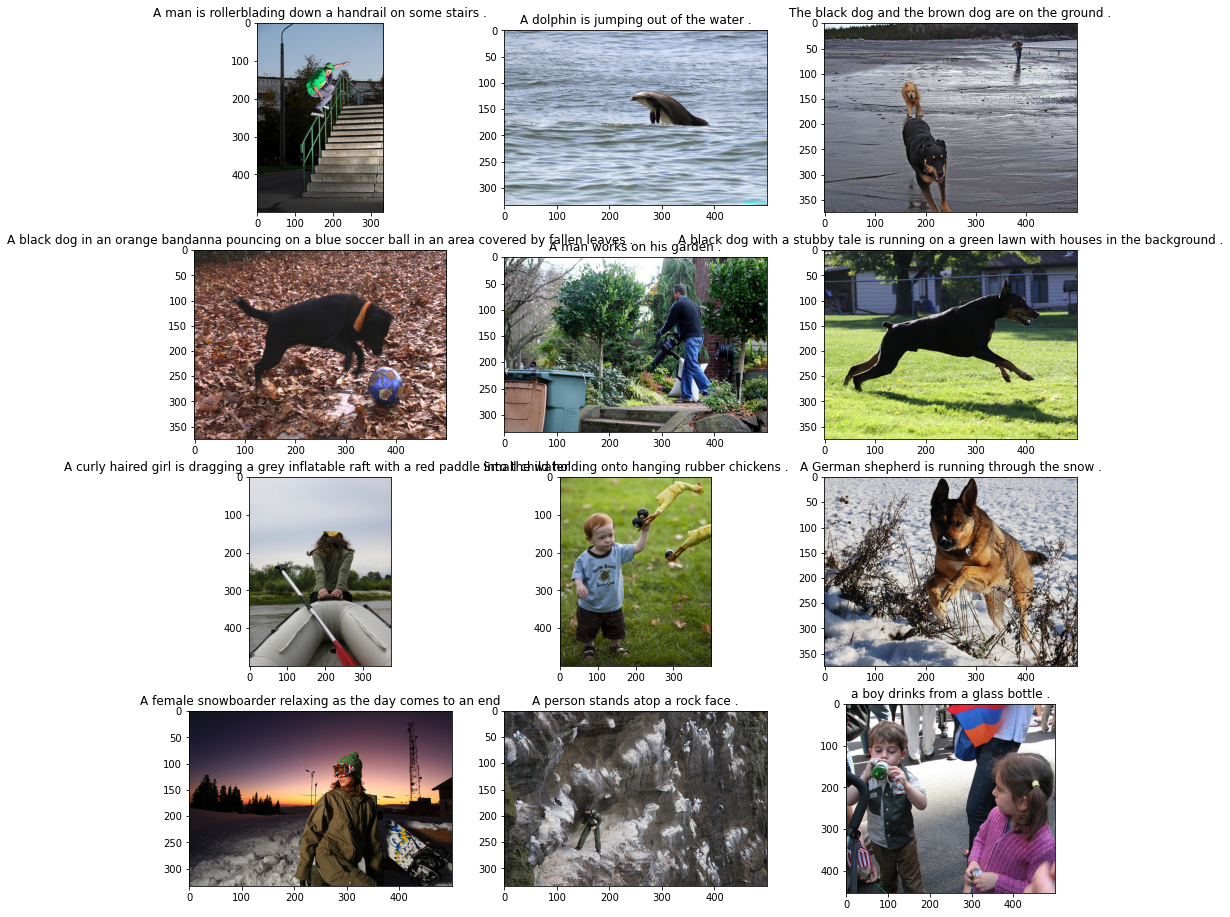

In [12]:
samples = random.sample(data, 12)
rows = 4
cols = 3
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16,16))

for i in range(rows):
    for j in range(cols):        
        if img_count < len(samples):
            axes[i, j].imshow(Image.open(samples[img_count]["path"]))
            axes[i, j].set_title(samples[img_count]["caption"])
            img_count+=1

In [13]:
#Import the dataset and read the text file into a seperate variable

text_file = "./flikr8k/captions.txt"

def load_doc(filename):
    
    with open(filename,"r") as f:
        text = f.read()
    
    return text

doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [14]:
all_img_id= [x["image"] for x in data]
all_img_path= [x["path"] for x in data]
annotations= [x["caption"] for x in data]

df = pd.DataFrame(list(zip(all_img_id, all_img_path,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,./flikr8k/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,./flikr8k/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,./flikr8k/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,./flikr8k/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,./flikr8k/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,./flikr8k/Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,./flikr8k/Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,./flikr8k/Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,./flikr8k/Images/997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [15]:
#Create a list which contains all the captions
annotations = annotations

#add the <start> & <end> token to all those captions as well
annotations = ["<start> " + x + " <end>" for x in annotations]

#Create a list which contains all the path to the images
all_img_path = all_img_path

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [18]:
#Create the vocabulary & the counter for the captions

vocabulary = {x for x in word_tokenize(" ".join(annotations)) if x not in stopwords}

val_count=Counter(x for x in word_tokenize(" ".join(annotations)) if x not in stopwords)

In [19]:
#Visualise the top 30 occuring words in the captions

val_count.most_common(30)

[('<', 80910),
 ('>', 80910),
 ('end', 40507),
 ('start', 40464),
 ('.', 36581),
 ('A', 22667),
 ('dog', 7984),
 ('man', 6829),
 ('Two', 4365),
 ('white', 3876),
 ('black', 3696),
 ('boy', 3442),
 (',', 3232),
 ('woman', 3228),
 ('girl', 3218),
 ('The', 3089),
 ('wearing', 3061),
 ('water', 2778),
 ('red', 2660),
 ('brown', 2475),
 ('people', 2446),
 ('young', 2432),
 ('blue', 2259),
 ('dogs', 2083),
 ('running', 2072),
 ('playing', 2008),
 ('shirt', 1806),
 ('standing', 1786),
 ('ball', 1779),
 ('little', 1625)]

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [20]:
# create the tokenizer

max_features = 5000
tokenizer = Tokenizer(num_words=max_features, oov_token="UNK", filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')

In [21]:
tokenizer.get_config()

{'num_words': 5000,
 'filters': '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': 'UNK',
 'document_count': 0,
 'word_counts': '{}',
 'word_docs': '{}',
 'index_docs': '{}',
 'index_word': '{}',
 'word_index': '{}'}

In [22]:
# Create word-to-index and index-to-word mappings.

tokenizer.fit_on_texts(annotations)

config = tokenizer.get_config()

word_to_index = config["word_index"]
index_to_word = config["index_word"]

In [23]:
# Create a word count of tokenizer to visulize the Top 30 occuring words after text processing
counter = Counter(eval(config["word_counts"]))
counter.most_common(30)

[('a', 62992),
 ('<start>', 40455),
 ('<end>', 40455),
 ('in', 18986),
 ('the', 18419),
 ('on', 10745),
 ('is', 9345),
 ('and', 8862),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7274),
 ('of', 6723),
 ('two', 5642),
 ('white', 3959),
 ('black', 3848),
 ('boy', 3581),
 ('are', 3504),
 ('woman', 3402),
 ('girl', 3328),
 ('to', 3176),
 ('wearing', 3062),
 ('at', 2915),
 ('people', 2883),
 ('water', 2790),
 ('red', 2691),
 ('young', 2630),
 ('brown', 2578),
 ('an', 2432),
 ('his', 2357),
 ('blue', 2279)]

In [24]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

sequences = tokenizer.texts_to_sequences(annotations)
cap_vector = pad_sequences(sequences)

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [25]:
#write your code here to create the dataset consisting of image paths

dataset = tf.data.Dataset.from_tensor_slices(list(set(all_img_path)))

2022-05-07 05:27:43.658413: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-07 05:27:45.939704: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14807 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


In [26]:
#write your code here for creating the function. This function should return images & their path

def load_image(image_path):
    preprocessed_img = tf.io.read_file(image_path)
    preprocessed_img = tf.image.decode_jpeg(preprocessed_img, channels=3)
    preprocessed_img = tf.image.resize(preprocessed_img, (299, 299))
    preprocessed_img = tf.keras.applications.inception_v3.preprocess_input(preprocessed_img)
    return preprocessed_img, image_path

In [27]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path

dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [28]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 13s 0us/step


In [29]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [30]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)

image_features = {}

# using tqdm for progress bar
for image,path in tqdm(dataset):  
    
    # feed images from newly created Dataset above to Inception V3 built above    
    batch_features = image_features_extract_model(image)
    
    # To squeeze out the features in a batch, to reshape features in order of (batch_size, 8*8, 2048)    
    batch_features_reshaped = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
    
    for batch_f, p in zip(batch_features_reshaped, path):
        path_of_feature = p.numpy().decode("utf-8")
        image_features[path_of_feature] =  batch_f.numpy()

100%|██████████| 253/253 [00:38<00:00,  6.65it/s]


In [31]:
with open("image_feature_map.pickle","wb") as w:
    w.write(pickle.dumps(image_features))

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [59]:
with open("image_feature_map.pickle","rb") as r:
    image_features = pickle.loads(r.read())

In [60]:
# train test  split

path_train, path_test, cap_train, cap_test = train_test_split(all_img_path, cap_vector)

In [61]:
# printing shapes of train test split

print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 30341
Testing data for images: 10114
Training data for Captions: 30341
Testing data for Captions: 10114


In [62]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(image_path, capt):
    image_tensor = image_features[image_path.decode('utf-8')]
    return image_tensor, capt

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [63]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier


BATCH_SIZE = 32
BUFFER_SIZE = 1000
def gen_dataset(images_data, captions_data):
    
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE)
 
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset


In [64]:
train_dataset=gen_dataset(path_train, cap_train)
test_dataset=gen_dataset(path_test, cap_test)

In [65]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(32, 64, 2048)
(32, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [66]:
embedding_dim = 256 
units = 512
vocab_size = 5000 + 1
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

In [67]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [68]:
tf.device('/gpu:0')

### Encoder

In [69]:
class Encoder(keras.Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = keras.layers.Dense(embedding_dim)
        
    def call(self, features):
        features = self.dense(features)
        features = tf.nn.relu(features)
        return features

In [70]:
encoder=Encoder(embedding_dim)

### Attention model

In [71]:
class Attention_model(keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        # features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        
        hidden_with_time_axis = tf.expand_dims(hidden, 1)  
        score = keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) 
        attention_weights = keras.activations.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features 
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

### Decoder

In [72]:
class Decoder(keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(units)
        self.embed = keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.d1 = keras.layers.Dense(self.units)
        self.d2 = keras.layers.Dense(vocab_size)
        

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention.call(features,hidden)
        embed =  self.embed(x) 
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) 
        output, state = self.gru(embed)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2]))
        output = self.d2(output)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [73]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [97]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [75]:
learning_rate = .0004
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction='none')

In [76]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
#     print("loss function : pred shape : ",pred.shape)
#     print("loss function : pred shape : ",real.shape)
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [77]:
checkpoint_path = "./checkpoint"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [78]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [79]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
#             print("train step : input shape : ", dec_input.shape)
#             print("train step : predi shape : ", predictions.shape)
#             print("train step : target shape : ", target[:, i].shape)
#             print("train step : expanded target shape : ", tf.expand_dims(target[:, i], 1).shape)
#             preds = tf.reduce_max(predictions, axis=1)
#             print("train step : predi softmax shape : ", tf.reduce_max(predictions, axis=1).shape)
            dec_input = tf.expand_dims(target[:, i], 1)
            
    avg_loss = (loss/int(target.shape[1]))
    
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))  
        
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [80]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    #write your code here to do the testing steps
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions)
        preds = tf.math.argmax(predictions, axis=1)
        dec_input = tf.expand_dims(preds, 1)

    avg_loss = (loss / int(target.shape[1]))

    return loss, avg_loss

In [81]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss=total_loss/test_num_steps
    
    return avg_test_loss

In [82]:
loss_plot = []
test_loss_plot = []
EPOCHS = 10

best_test_loss=100
pbar = tqdm(range(0, EPOCHS))
for epoch in pbar:
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        pbar.set_postfix({'inner': batch})

    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)

    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

 10%|█         | 1/10 [03:35<32:22, 215.87s/it, inner=948]

For epoch: 1, the train loss is 1.276, & test loss is 2.431
Time taken for 1 epoch 215.70467853546143 sec

Test loss has been reduced from 100.000 to 2.431


 20%|██        | 2/10 [05:31<20:54, 156.77s/it, inner=948]

For epoch: 2, the train loss is 1.011, & test loss is 2.359
Time taken for 1 epoch 115.20800018310547 sec

Test loss has been reduced from 2.431 to 2.359


 30%|███       | 3/10 [07:26<16:03, 137.67s/it, inner=0]  

For epoch: 3, the train loss is 0.925, & test loss is 2.401
Time taken for 1 epoch 114.93469429016113 sec



 40%|████      | 4/10 [09:21<12:53, 128.91s/it, inner=0]  

For epoch: 4, the train loss is 0.864, & test loss is 2.410
Time taken for 1 epoch 115.49005150794983 sec



 50%|█████     | 5/10 [11:16<10:19, 123.93s/it, inner=948]

For epoch: 5, the train loss is 0.814, & test loss is 2.357
Time taken for 1 epoch 114.90485286712646 sec

Test loss has been reduced from 2.359 to 2.357


 60%|██████    | 6/10 [13:11<08:03, 120.85s/it, inner=0]  

For epoch: 6, the train loss is 0.772, & test loss is 2.384
Time taken for 1 epoch 114.85961556434631 sec



 70%|███████   | 7/10 [15:06<05:56, 118.99s/it, inner=0]  

For epoch: 7, the train loss is 0.733, & test loss is 2.546
Time taken for 1 epoch 115.18041658401489 sec



 80%|████████  | 8/10 [17:02<03:55, 117.81s/it, inner=0]  

For epoch: 8, the train loss is 0.697, & test loss is 2.596
Time taken for 1 epoch 115.28329515457153 sec



 90%|█████████ | 9/10 [18:57<01:57, 117.12s/it, inner=0]  

For epoch: 9, the train loss is 0.666, & test loss is 2.728
Time taken for 1 epoch 115.60386800765991 sec



100%|██████████| 10/10 [20:52<00:00, 125.21s/it, inner=948]

For epoch: 10, the train loss is 0.635, & test loss is 2.725
Time taken for 1 epoch 114.38024544715881 sec



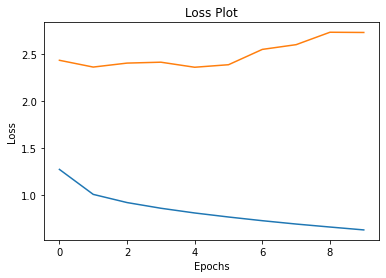

In [83]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [131]:
def evaluate(image):
    max_length = 39
    attention_features_shape = 64
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() #extract the predicted id(embedded value) which carries the max value
        #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot, predictions

        dec_input = tf.expand_dims([predicted_id], 0)
        
        result.append(tokenizer.index_word[predicted_id])

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, predictions


In [132]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [133]:
from nltk.translate.bleu_score import sentence_bleu

In [134]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

BELU score: 13.256373011140136
Real Caption: A little girl climbing the stairs to her playhouse .
Prediction Caption: a girl climbing into a wooden


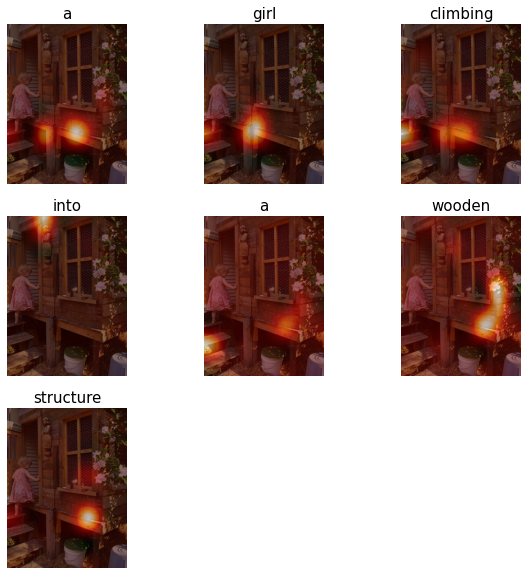

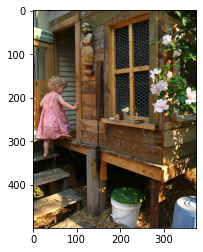

In [135]:
rid = np.random.randint(0, len(data))
test_image = data[i]["path"]

# test_image = './Images/413231421_43833a11f5.jpg'
# real_caption = '<start> black dog is digging in the snow <end>'

real_caption = data[i]["caption"]
result, attention_plot, pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)

image_sample = Image.open(test_image)
plt.imshow(image_sample)
plt.show()

### Beam Search(optional)

In [86]:
def beam_evaluate(image, beam_index = []):

    #write your code to evaluate the result using beam search
                  
    return final_caption


In [93]:
# captions=beam_evaluate(test_image)
# print(captions)